In [189]:
%autosave 100

import numpy as np
import math
import matplotlib.pyplot as plt

Autosaving every 100 seconds


In [190]:
T_0 = 293         # K
Q = 7 * 10**5     # Дж/кг   ??? 8 * 10**5
C = 1980          # Дж/кг*К ??? 1990
T_m = T_0 + Q / C # K
K = 1.6 * 10**6   # 1/с
E = 8 * 10**4     # Дж/моль
R = 8.314         # Дж/моль*К
alpha = 1         # 
po = 830           # кг/м^3
lambd = 0.13      # Дж/м*с*К
D = lambd / (po * C)# 8 * 10**(-12) # м^2/с

beta = R * T_m / E
gamma = R * T_m**2 / (E * (T_m - T_0))

U = ( 2*K*lambd / (Q*po) *(T_m - T_0) * (R*T_m/E)**2 * math.exp(-E/(R*T_m)) ) ** 0.5
dd = D / U
dh = lambd / (po * C * U)
dr = dh * beta

dz = dr / 4
L  = 10 * dh
steps = round(L / dz) + 1

dt = dz / U
times = 100

print('D =',D)
print('dd =',dd)
print('dh =',dh)
print('dr =',dr)
print('dz =',dz)
print('L =',L)
print('steps =',steps)
print('dt =',dt)
print('times =',times)

def x0(z):
    return 0 if z == 0 else 1

def t0(z):
    return T_m if z == 0 else T_0

def W_(X, T):
    return [-K * X[i]**alpha * math.exp(-E / (R * T[i])) for i in range(len(X))]

D = 7.910429597176586e-08
dd = 0.003990197021950859
dh = 0.003990197021950858
dr = 0.00026810607273715245
dz = 6.702651818428811e-05
L = 0.03990197021950858
steps = 596
dt = 3.3809669875089994
times = 100


In [191]:
def solve(X_old, T_old):
    # predictor X
    alpha_ = np.zeros([len(X_old)], dtype = float)
    beta_  = np.zeros([len(X_old)], dtype = float)
    
    a_ = D / dz**2
    b_ = -2*D / dz**2 - 1. / dt
    c_ = D / dz**2
    d_  = np.zeros([len(X_old)], dtype = float)
    for i in range(len(X_old)):
        d_[i] = K * X_old[i]**alpha * math.exp(-E/(R*T_old[i])) - X_old[i] / dt
    
    
    alpha_[0] = -c_ / b_
    beta_[0] = d_[0] / b_
    for i in range(1, len(alpha_)):
        alpha_[i] = -c_ / (a_ * alpha_[i - 1] + b_)
        beta_[i] = (d_[i] - a_ * beta_[i - 1]) / (a_ * alpha_[i - 1] + b_)
    
    X_pred = np.zeros([len(X_old)], dtype = float)
    X_pred[-1] = (d_[-1] - a_ * beta_[-2]) / (a_ * alpha_[-2] + b_ + c_)
    for i in range(len(X_pred) - 1, 0, -1):
        X_pred[i-1] = alpha_[i-1] * X_pred[i] + beta_[i-1] 
        
    # predictor T
    alpha_ = np.zeros([len(X_old)], dtype = float)
    beta_  = np.zeros([len(X_old)], dtype = float)
    
    a_ = lambd / (po * C * dz**2)
    b_ = -2*lambd / (po * C * dz**2) - 1. / dt
    c_ = lambd / (po * C * dz**2)
    d_  = np.zeros([len(X_old)], dtype = float)
    for i in range(len(X_old)):
        d_[i] = -Q / C * K * X_old[i]**alpha * math.exp(-E/(R*T_old[i])) - T_old[i] / dt 
    d_[0] -= a_ * T_m
    
    
    alpha_[0] = -c_ / b_
    beta_[0] = d_[0] / b_
    for i in range(1, len(alpha_)):
        alpha_[i] = -c_ / (a_ * alpha_[i - 1] + b_)
        beta_[i] = (d_[i] - a_ * beta_[i - 1]) / (a_ * alpha_[i - 1] + b_)
    
    T_pred = np.zeros([len(X_old)], dtype = float)
    T_pred[-1] = (d_[-1] - a_ * beta_[-2]) / (a_ * alpha_[-2] + b_ + c_)
    for i in range(len(T_pred) - 1, 0, -1):
        T_pred[i-1] = alpha_[i-1] * T_pred[i] + beta_[i-1] 
        
    # corrector X
    alpha_ = np.zeros([len(X_old)], dtype = float)
    beta_  = np.zeros([len(X_old)], dtype = float)
    
    a_ = D / dz**2
    b_ = -2*D / dz**2 - 1. / dt
    c_ = D / dz**2
    d_  = np.zeros([len(X_old)], dtype = float)
    for i in range(len(X_old)):
        d_[i] = K * X_pred[i]**alpha * math.exp(-E/(R*T_pred[i])) - X_old[i] / dt
    
    alpha_[0] = -c_ / b_
    beta_[0] = d_[0] / b_
    for i in range(1, len(alpha_)):
        alpha_[i] = -c_ / (a_ * alpha_[i - 1] + b_)
        beta_[i] = (d_[i] - a_ * beta_[i - 1]) / (a_ * alpha_[i - 1] + b_)
    
    X_corr = np.zeros([len(X_old)], dtype = float)
    X_corr[-1] = (d_[-1] - a_ * beta_[-2]) / (a_ * alpha_[-2] + b_ + c_)
    for i in range(len(X_corr) - 1, 0, -1):
        X_corr[i-1] = alpha_[i-1] * X_corr[i] + beta_[i-1] 
    
    # corrector T
    alpha_ = np.zeros([len(X_old)], dtype = float)
    beta_  = np.zeros([len(X_old)], dtype = float)
    
    a_ = lambd / (po * C * dz**2)
    b_ = -2*lambd / (po * C * dz**2) - 1. / dt
    c_ = lambd / (po * C * dz**2)
    d_  = np.zeros([len(X_old)], dtype = float)
    for i in range(len(X_old)):
        d_[i] = -Q / C * K * X_pred[i]**alpha * math.exp(-E/(R*T_pred[i])) - T_old[i] / dt 
    d_[0] -= a_ * T_m
    
    alpha_[0] = -c_ / b_
    beta_[0] = d_[0] / b_
    for i in range(1, len(alpha_)):
        alpha_[i] = -c_ / (a_ * alpha_[i - 1] + b_)
        beta_[i] = (d_[i] - a_ * beta_[i - 1]) / (a_ * alpha_[i - 1] + b_)
    
    T_corr = np.zeros([len(X_old)], dtype = float)
    T_corr[-1] = (d_[-1] - a_ * beta_[-2]) / (a_ * alpha_[-2] + b_ + c_)
    for i in range(len(T_corr) - 1, 0, -1):
        T_corr[i-1] = alpha_[i-1] * T_corr[i] + beta_[i-1] 
    
    return (X_corr, T_corr)

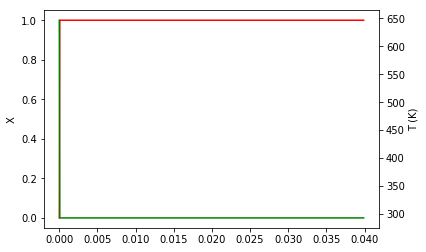

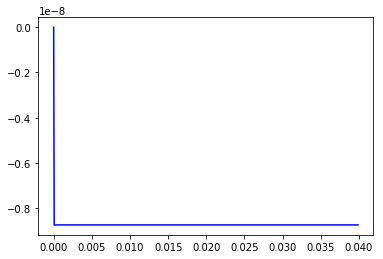

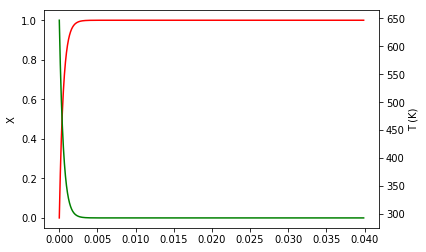

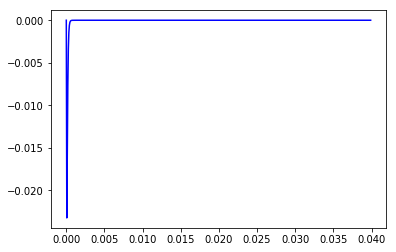

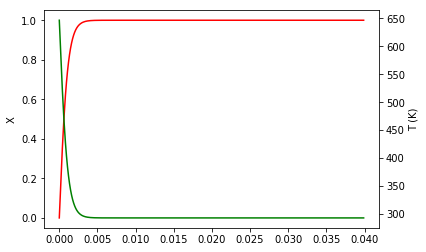

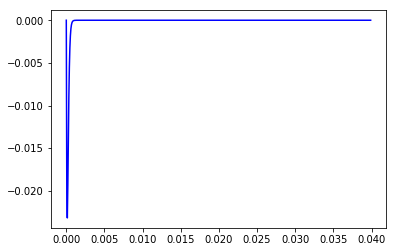

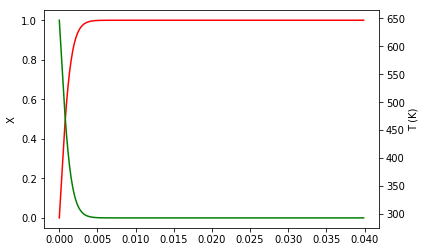

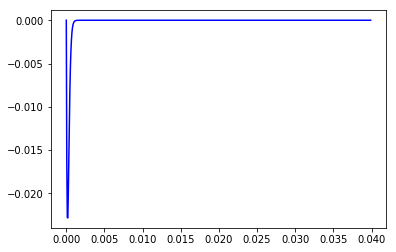

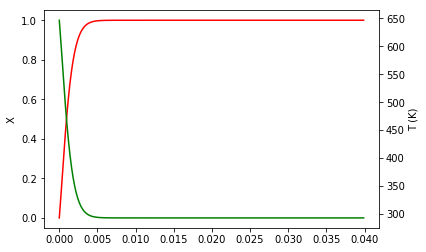

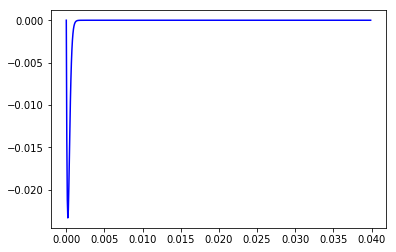

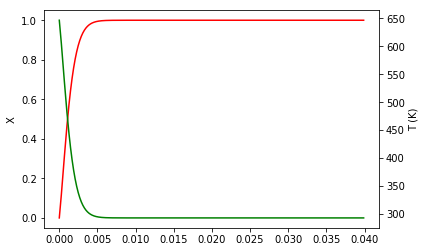

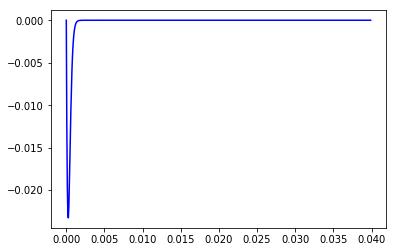

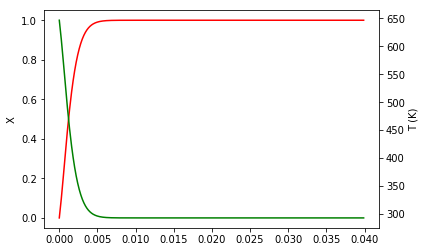

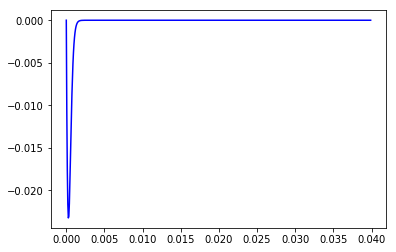

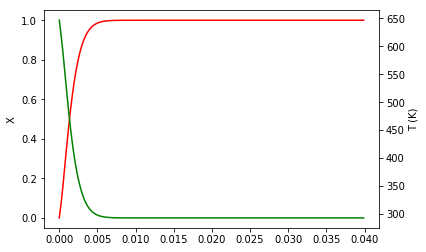

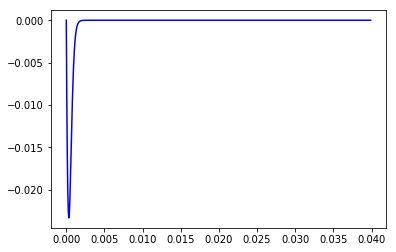

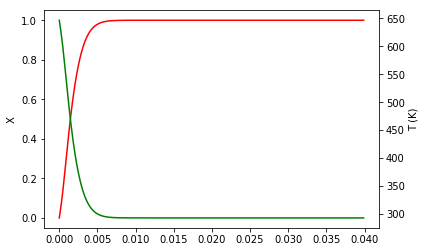

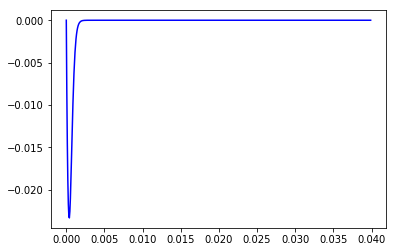

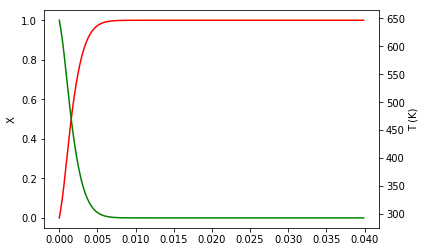

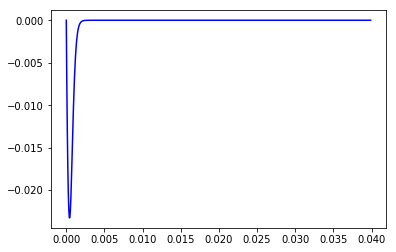

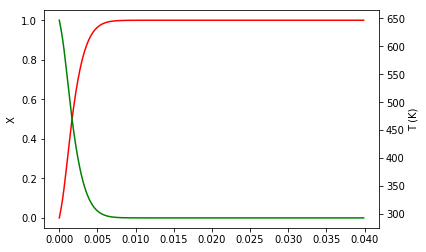

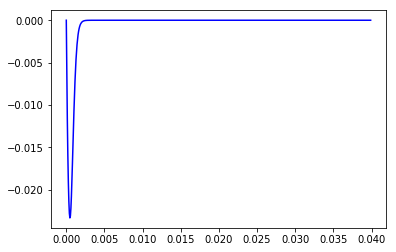

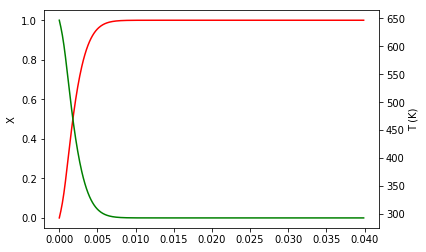

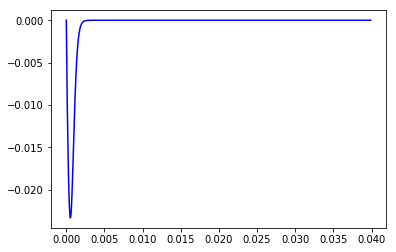

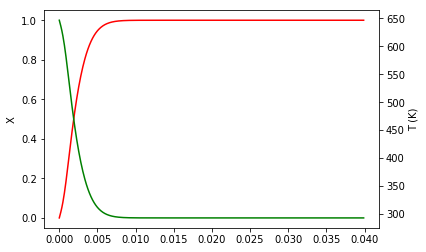

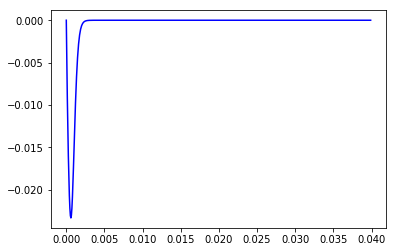

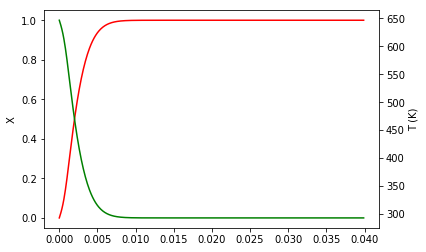

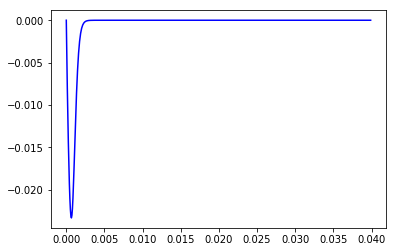

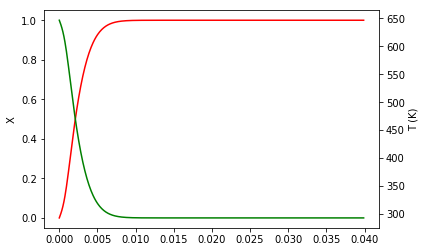

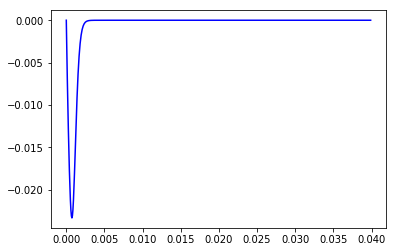

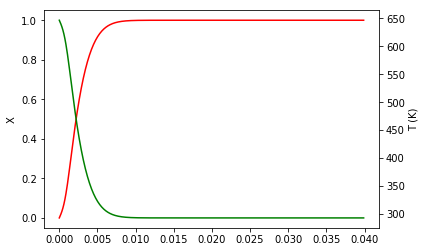

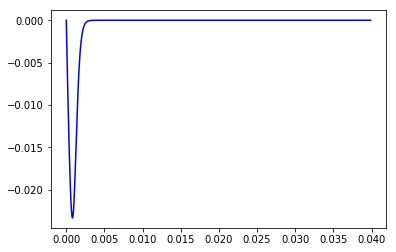

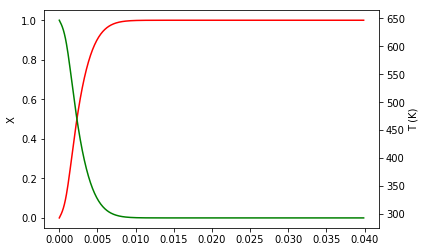

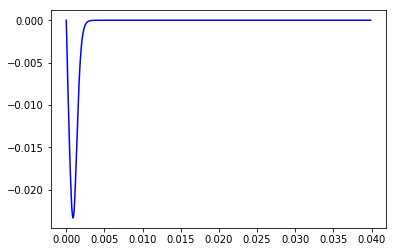

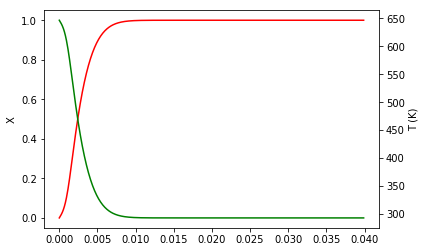

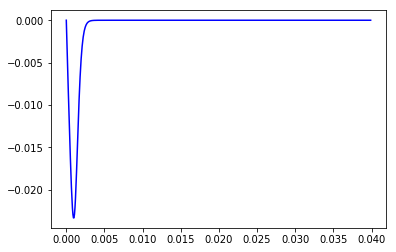

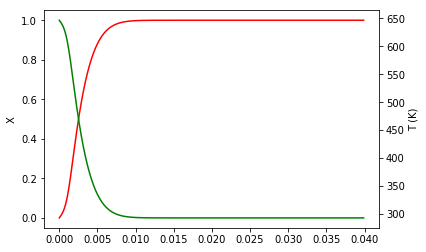

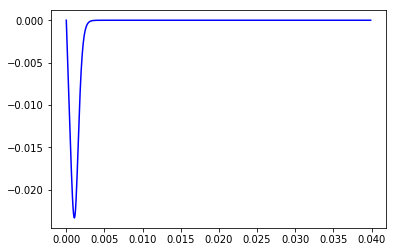

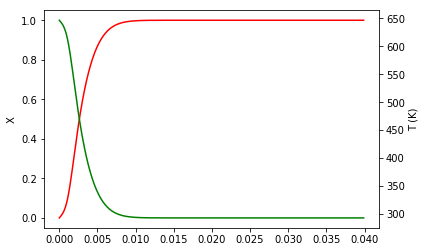

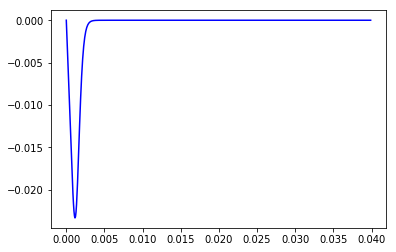

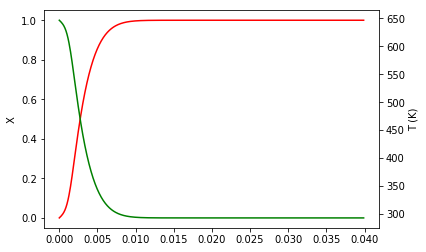

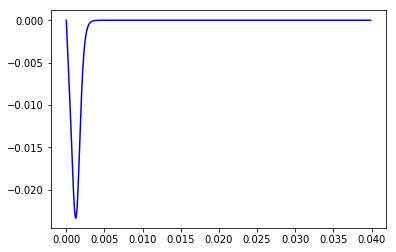

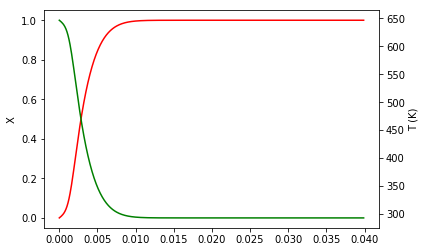

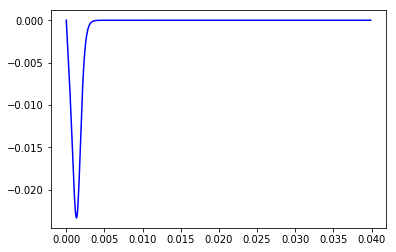

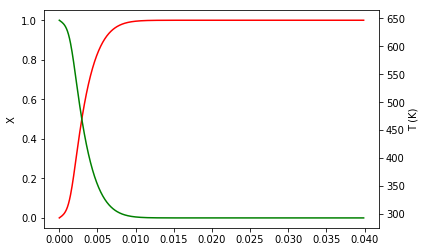

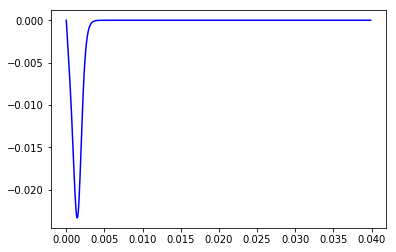

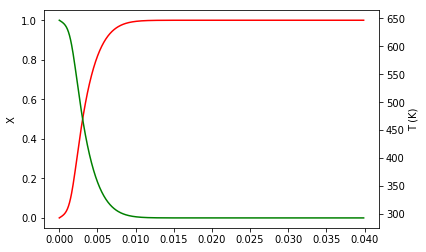

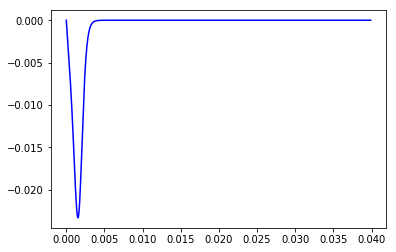

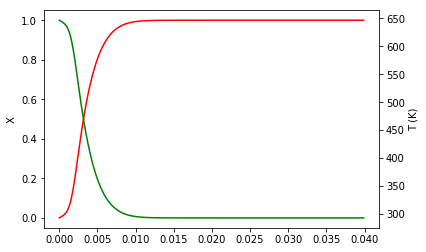

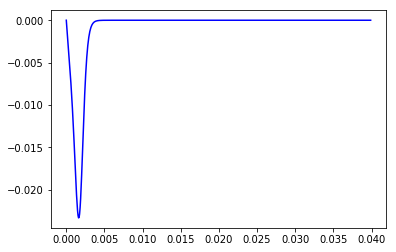

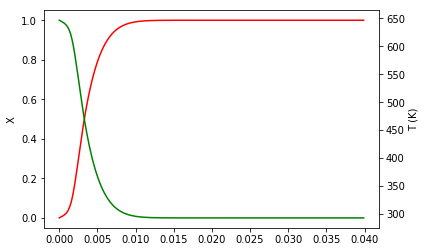

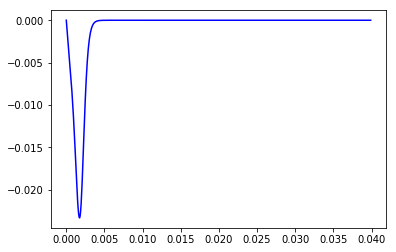

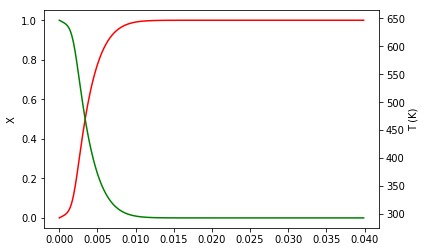

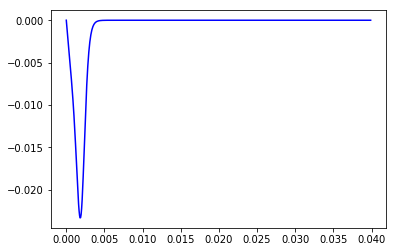

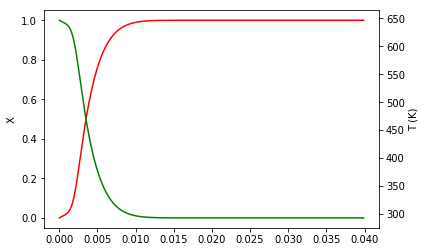

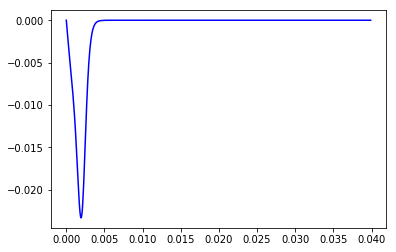

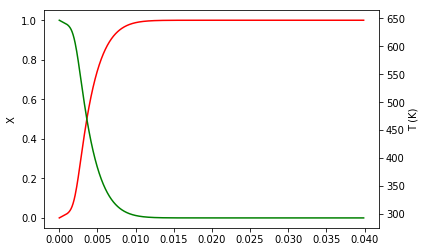

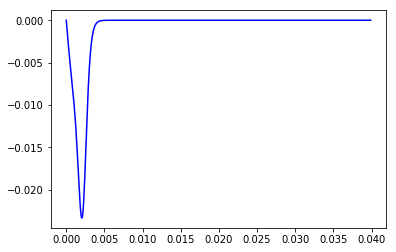

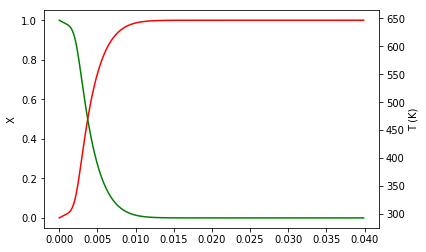

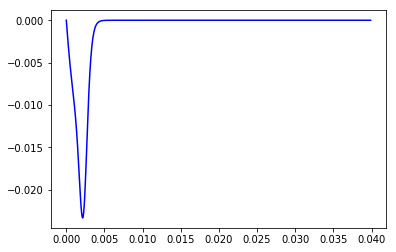

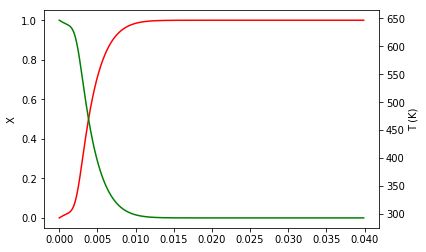

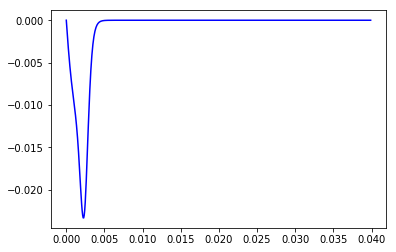

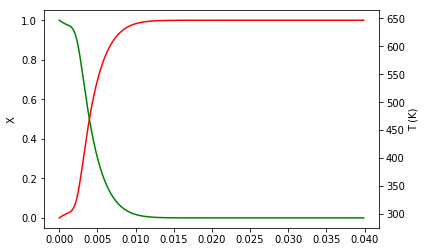

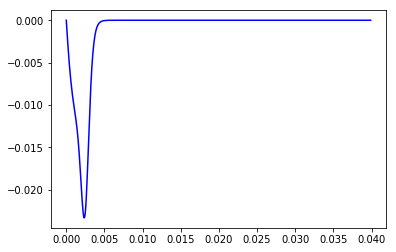

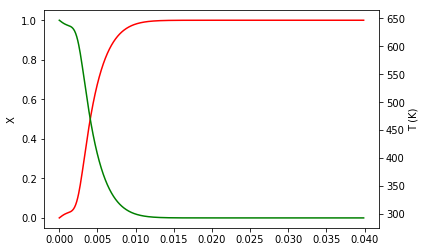

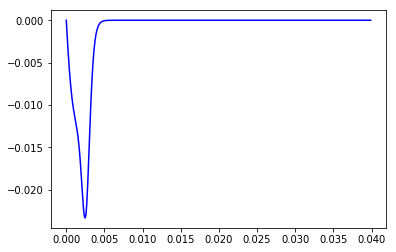

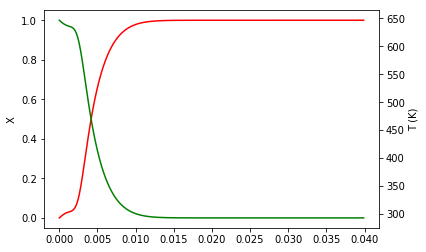

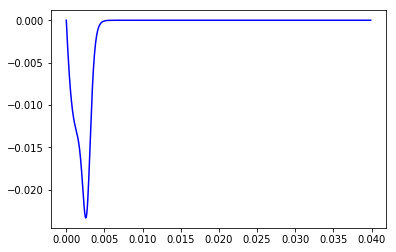

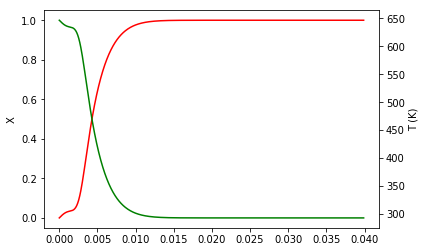

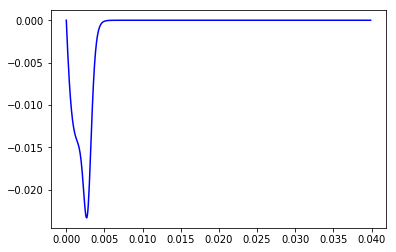

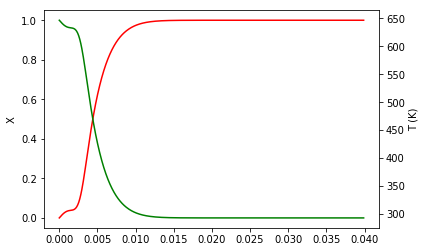

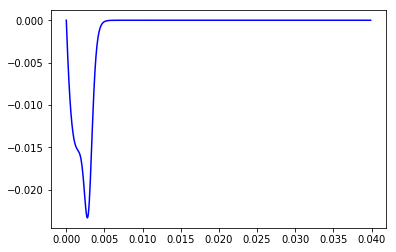

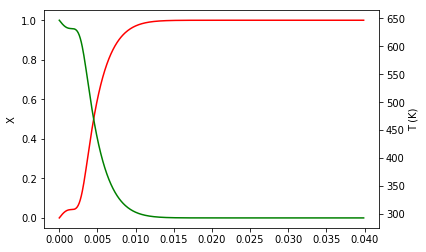

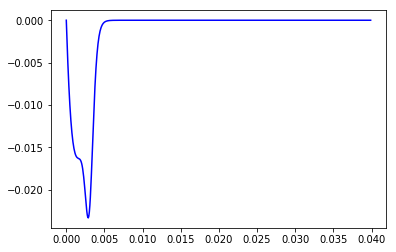

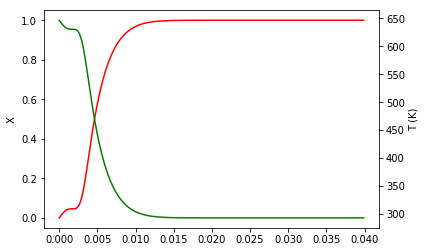

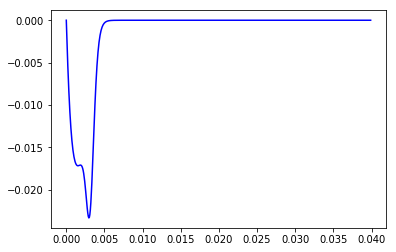

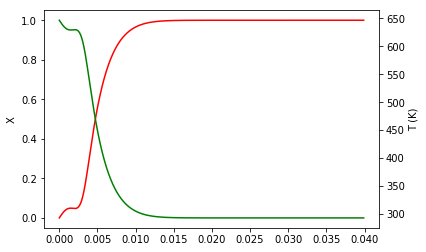

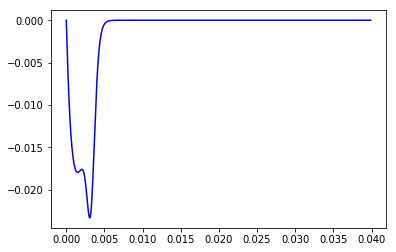

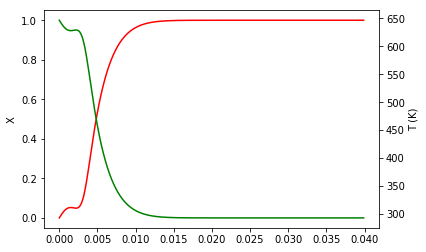

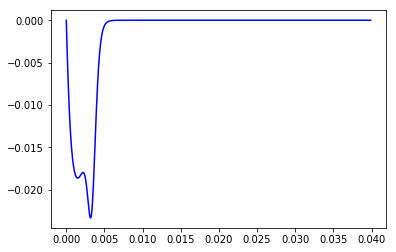

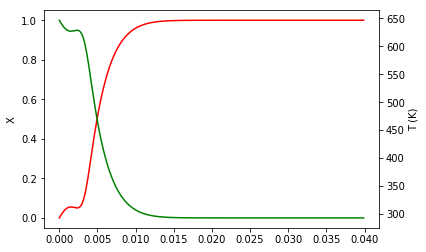

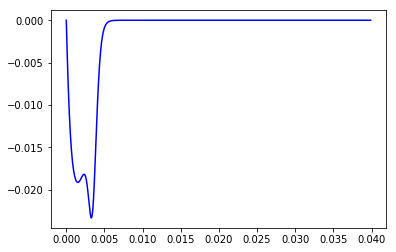

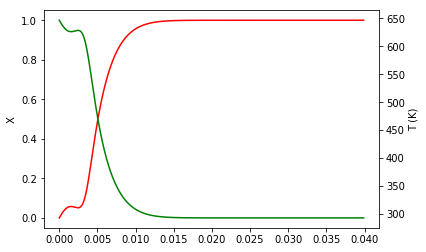

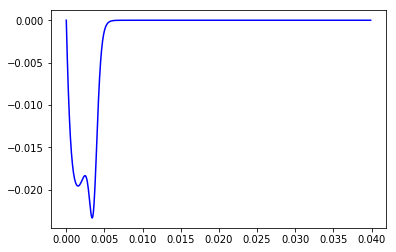

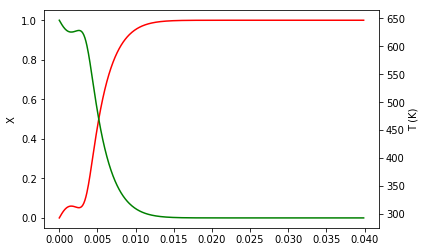

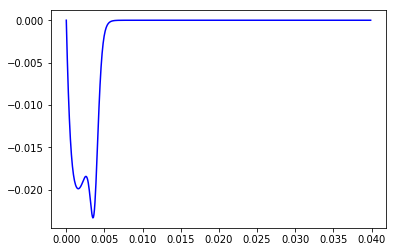

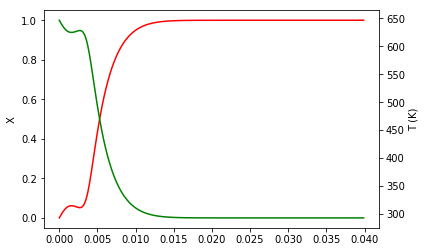

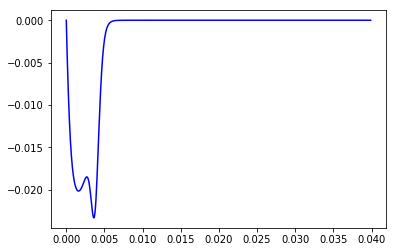

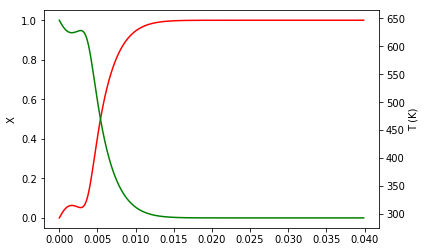

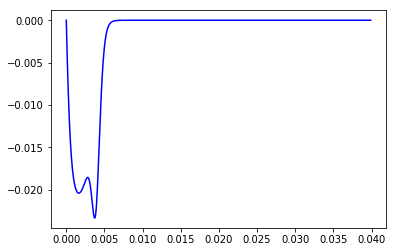

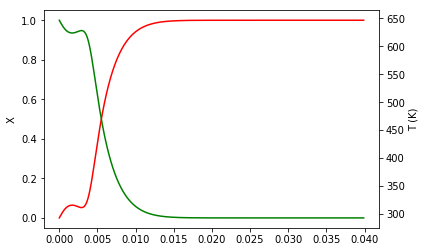

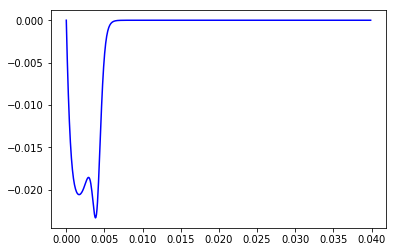

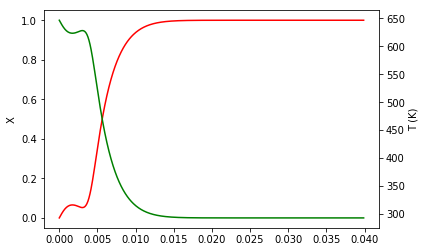

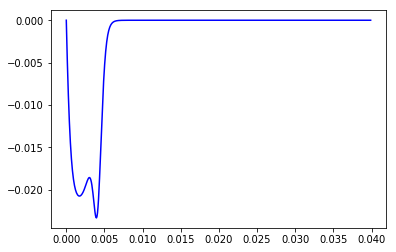

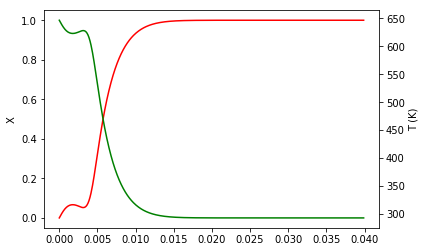

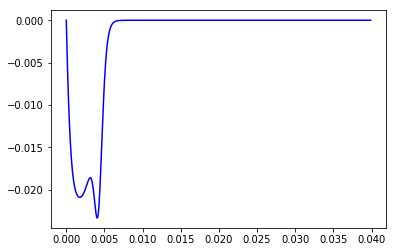

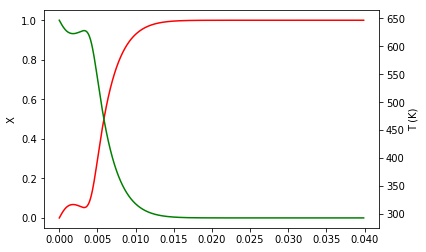

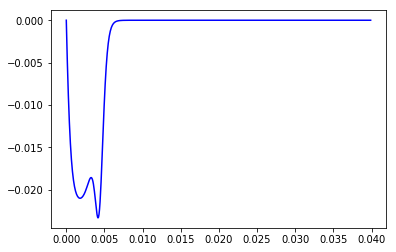

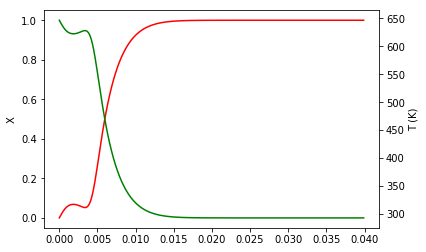

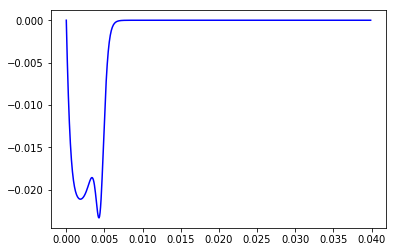

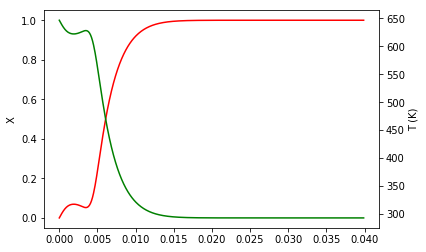

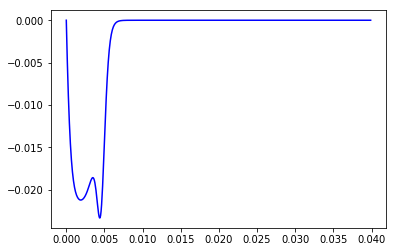

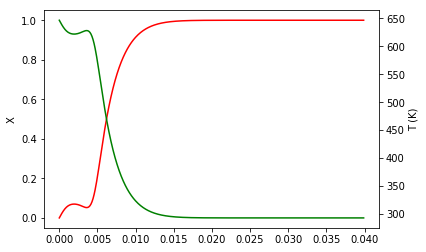

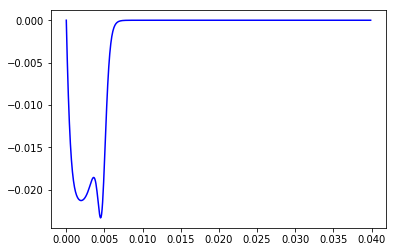

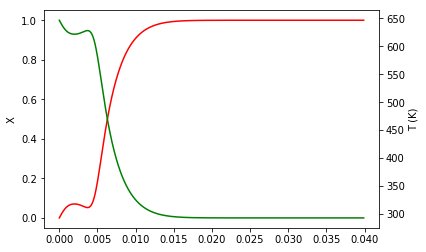

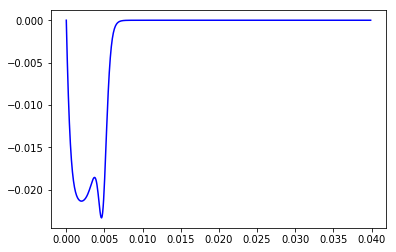

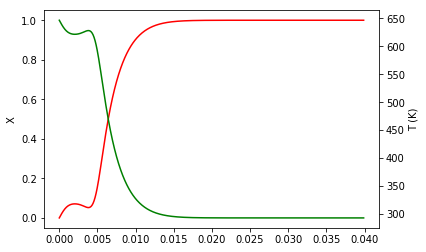

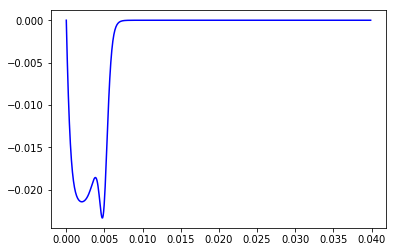

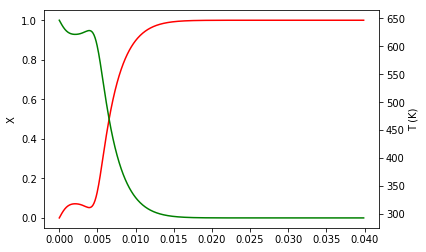

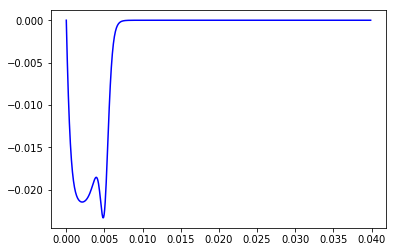

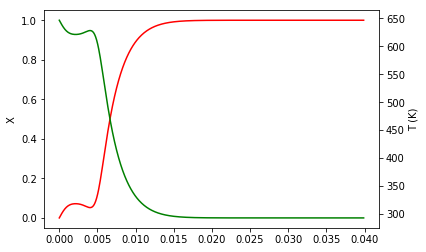

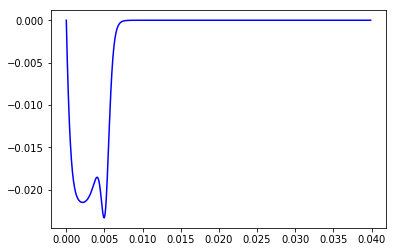

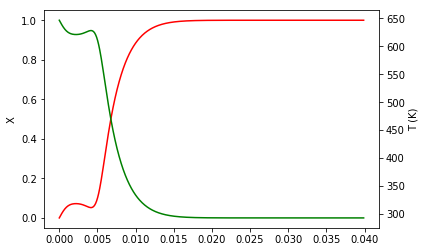

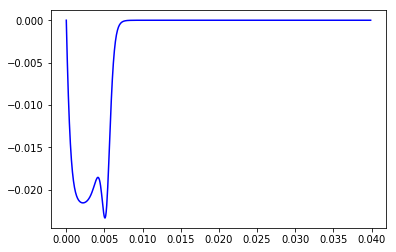

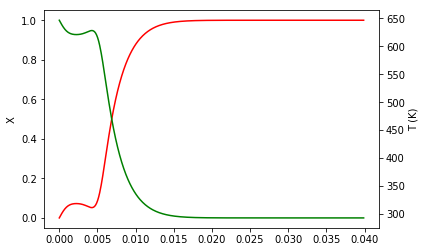

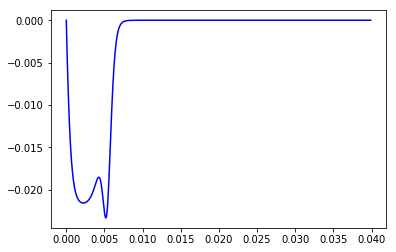

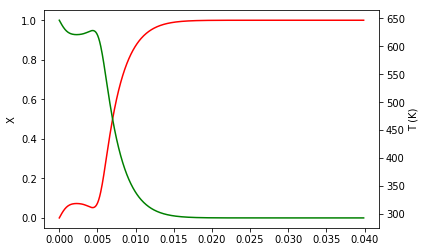

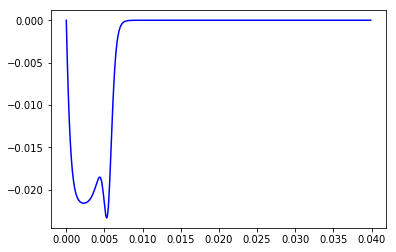

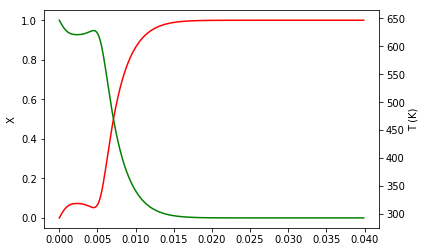

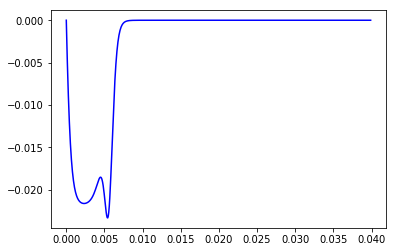

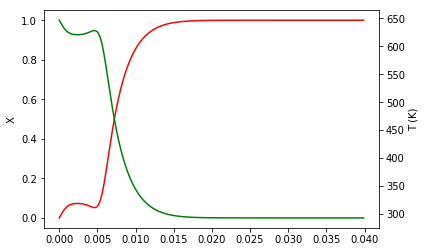

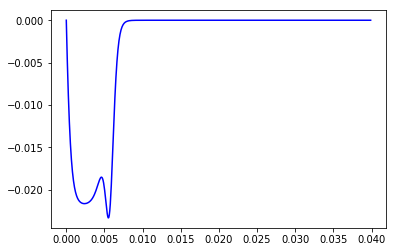

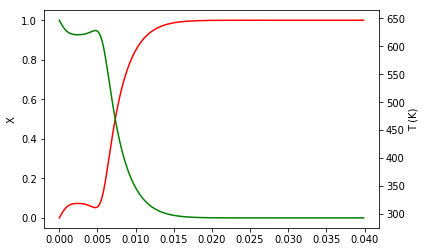

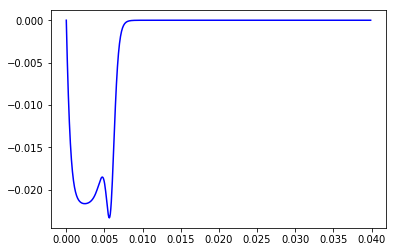

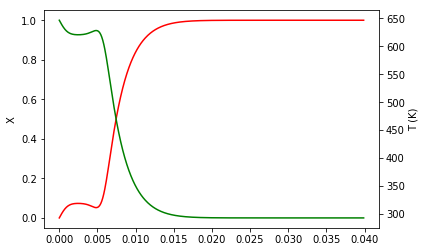

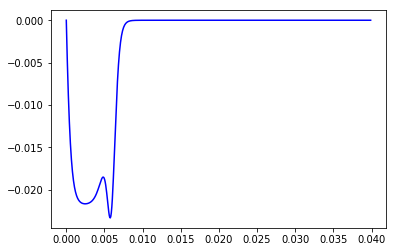

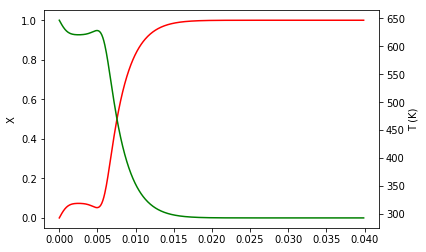

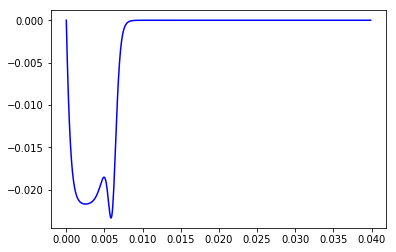

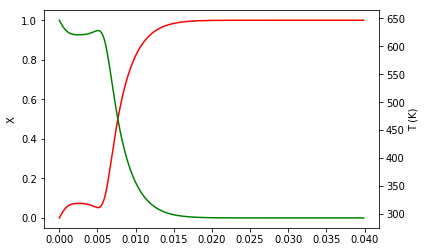

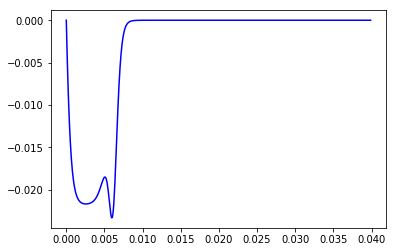

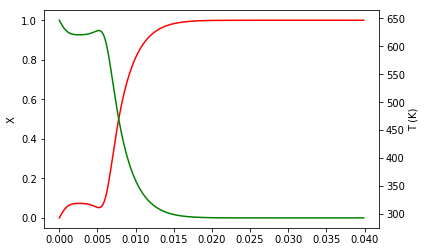

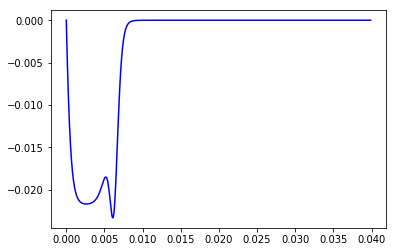

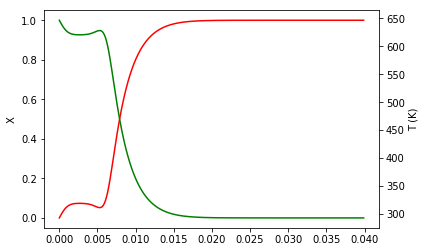

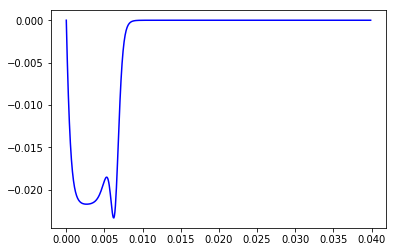

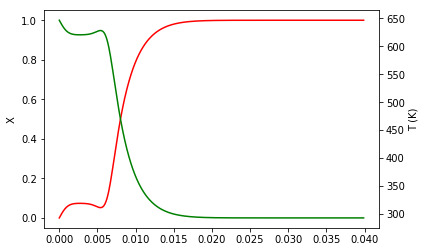

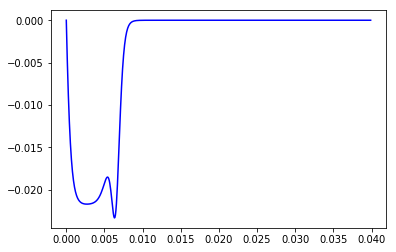

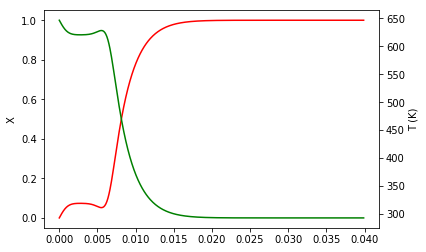

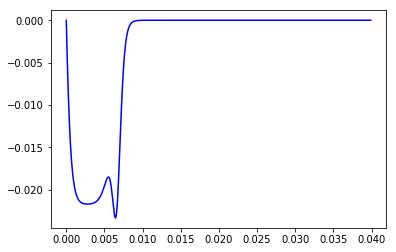

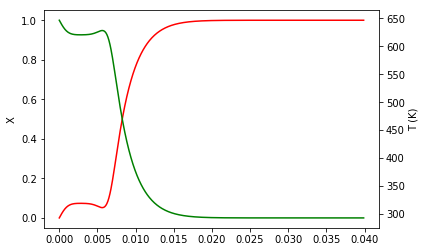

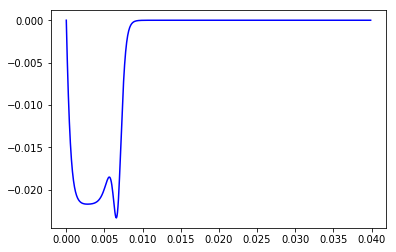

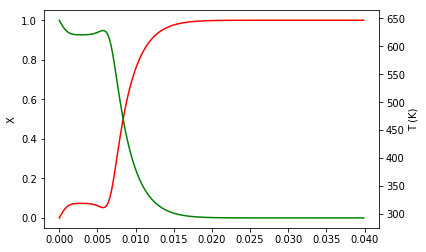

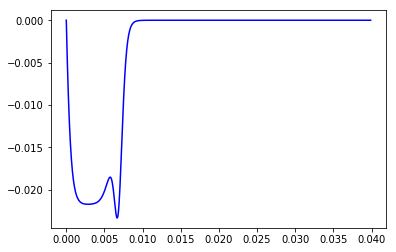

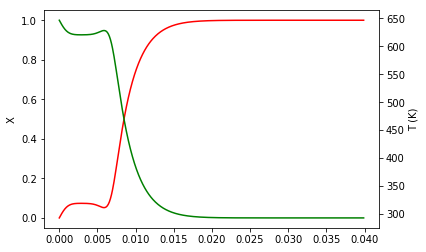

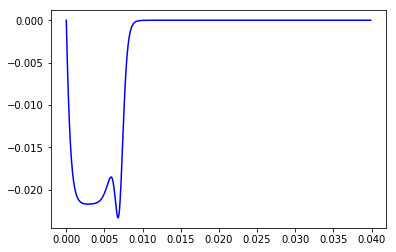

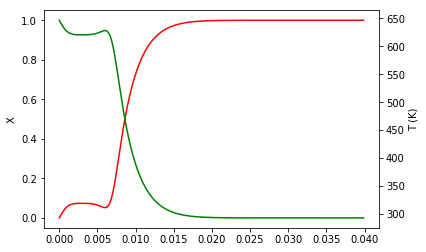

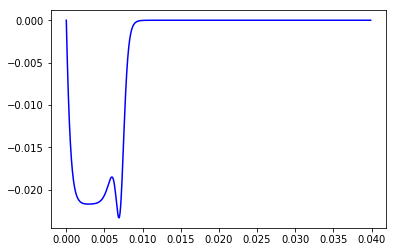

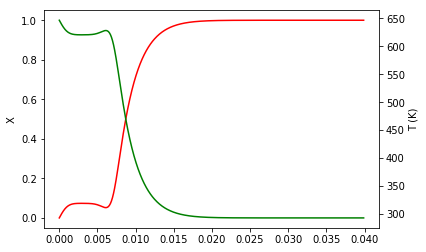

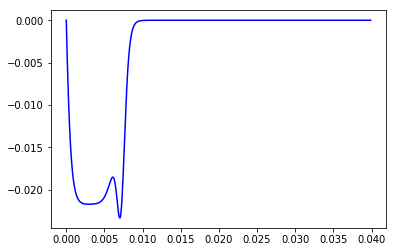

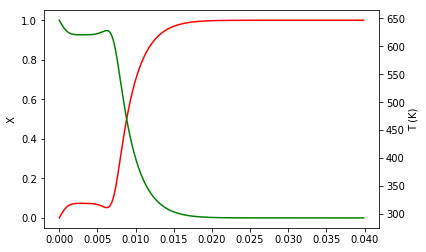

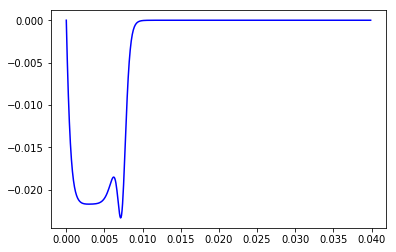

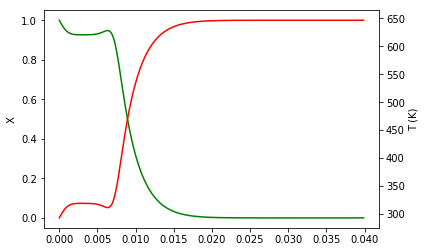

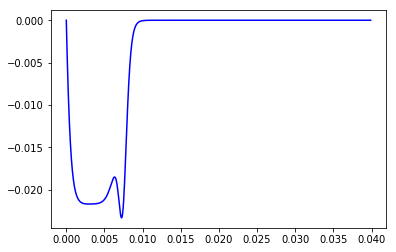

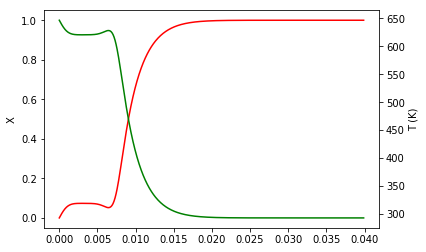

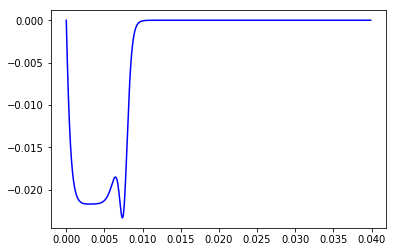

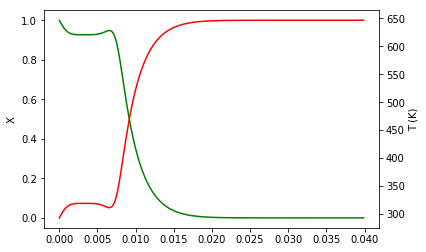

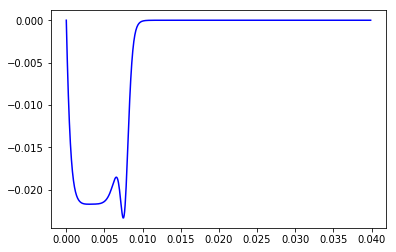

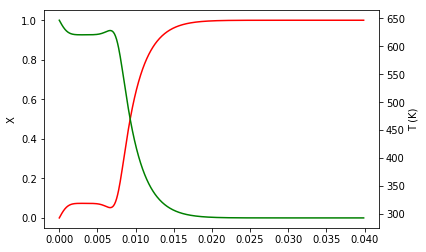

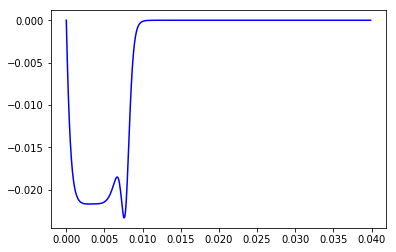

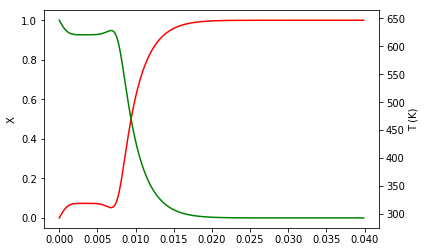

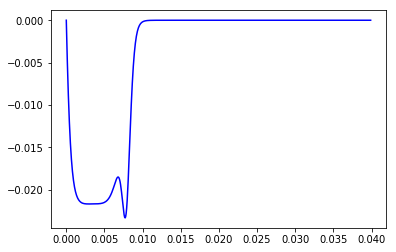

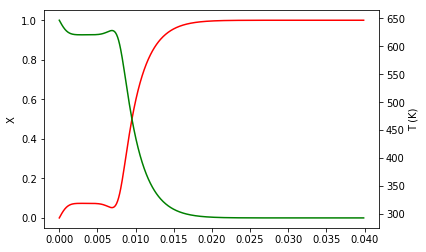

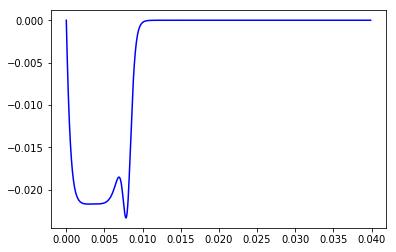

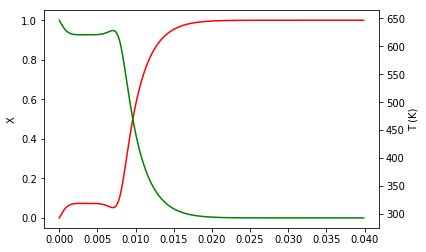

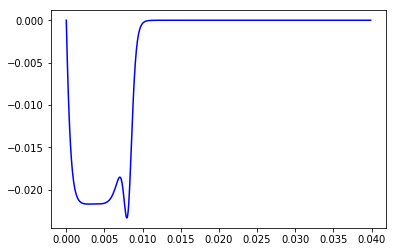

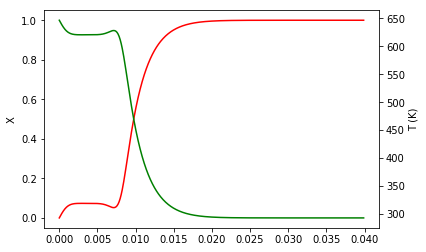

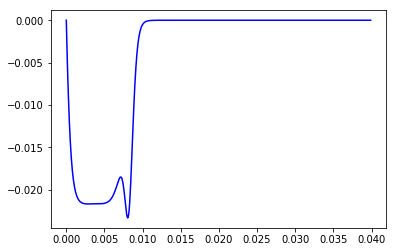

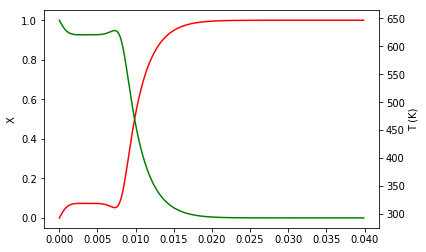

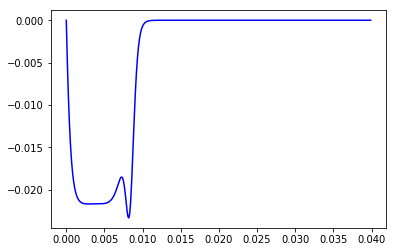

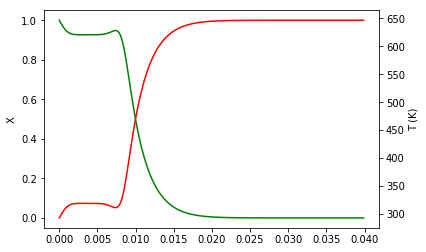

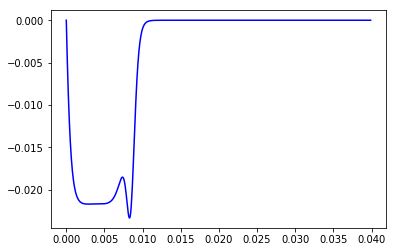

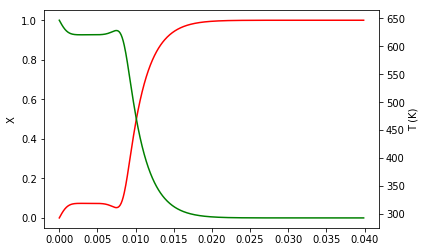

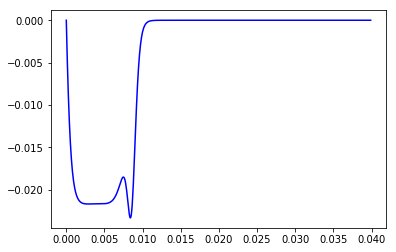

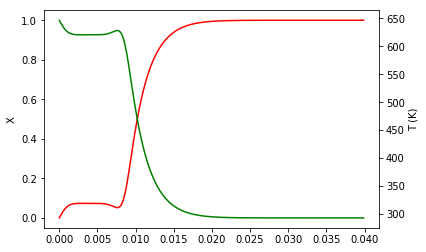

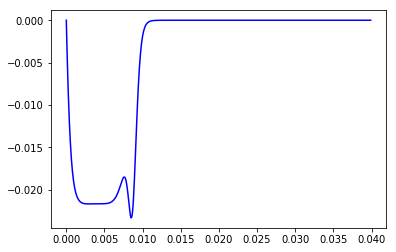

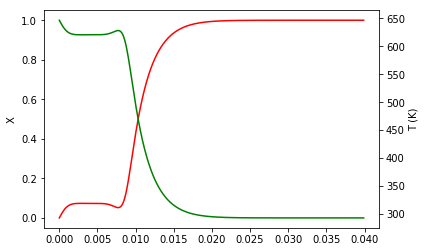

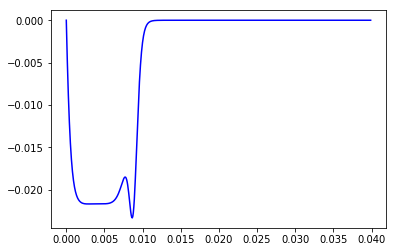

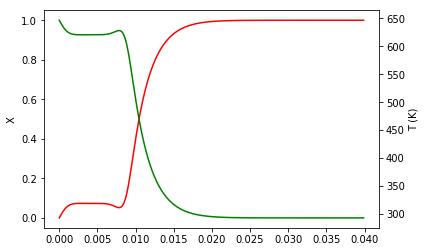

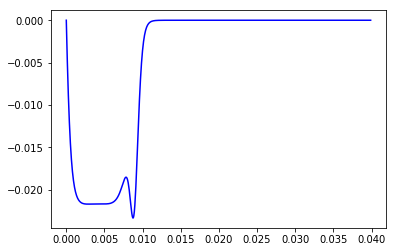

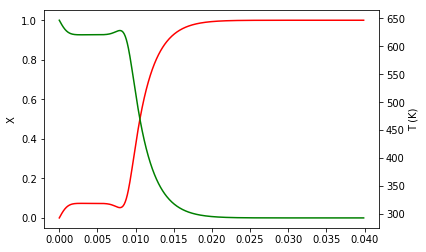

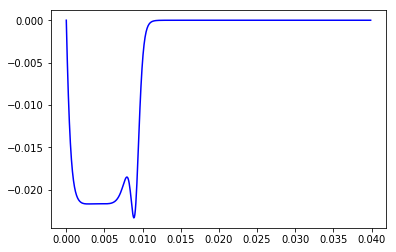

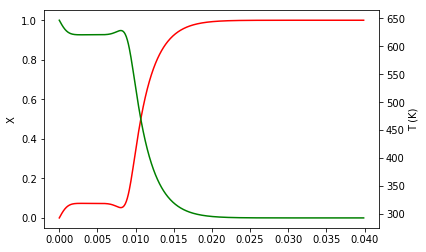

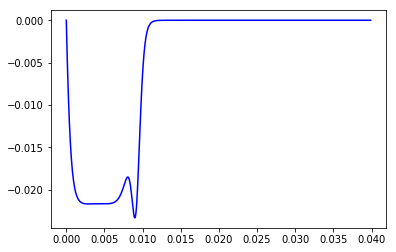

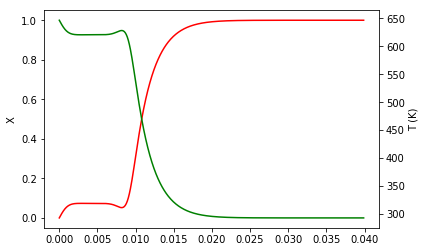

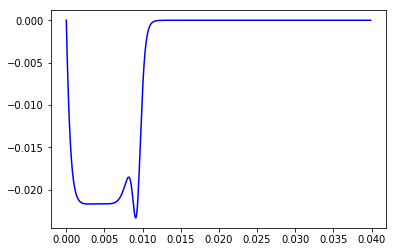

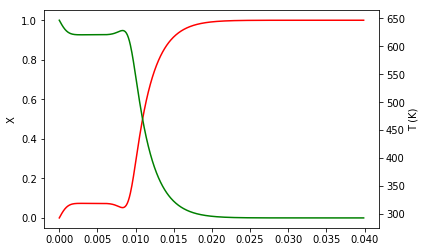

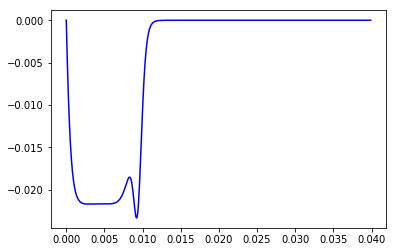

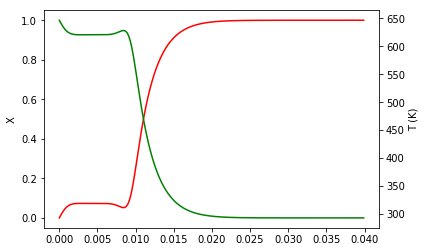

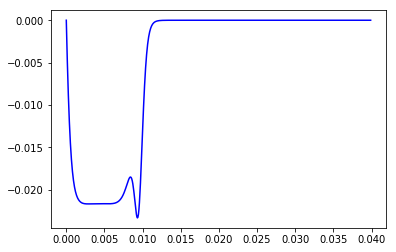

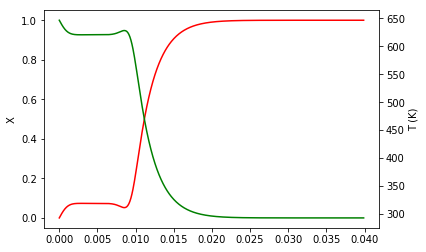

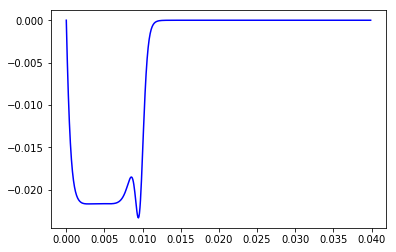

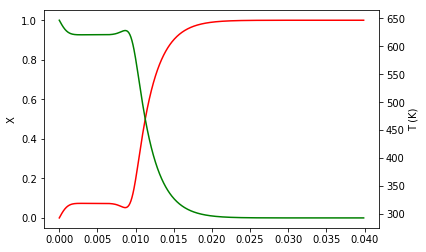

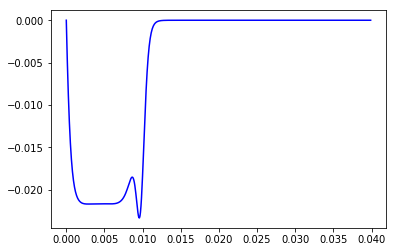

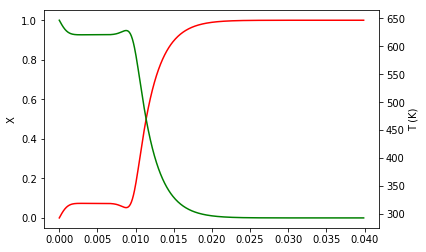

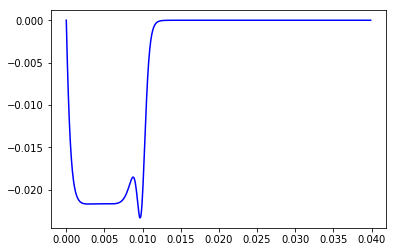

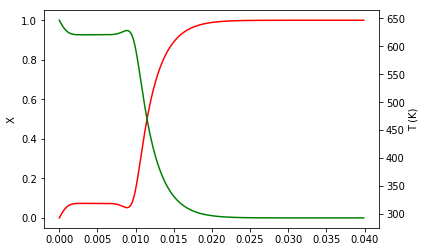

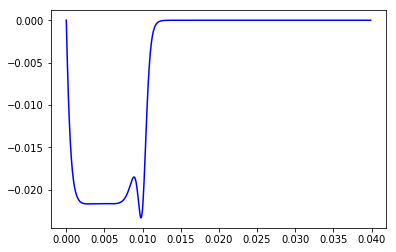

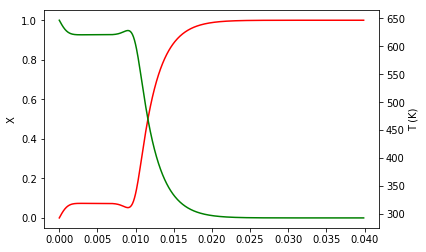

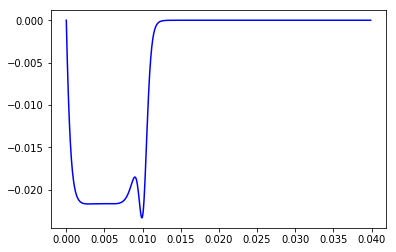

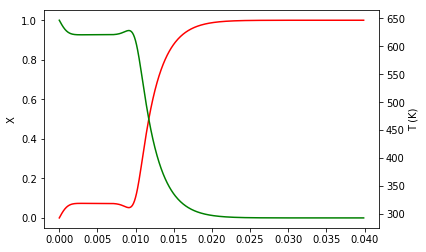

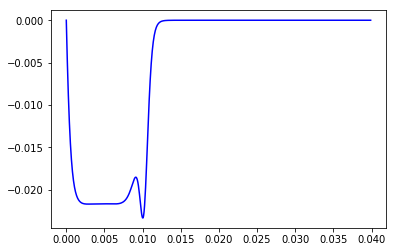

In [196]:
zs = np.arange(0, L, dz)
T = np.zeros([times, steps], dtype = float)
X = np.zeros([times, steps], dtype = float)
W = np.zeros([times, steps], dtype = float)

for (i,z) in enumerate(zs):
    X[0,i] = x0(z)
    T[0,i] = t0(z)
W[0,:] = W_(X[0,:], T[0,:])

for time in range(times):
    if time > 0:
        X[time, 0] = 0
        T[time, 0] = T_m
        (X[time, 1:-1], T[time, 1:-1]) = solve(X[time - 1, 1:-1], T[time - 1, 1:-1])
        X[time, -1] = X[time, -2]
        T[time, -1] = T[time, -2]
        W[time, : ] = W_(X[time, :], T[time, :])
            
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    ax2 = fig.add_axes(ax1.get_position(), frameon=False)
    ax1.plot(zs, X[time,:], label = 'X', color = 'red')
    ax2.plot(zs, T[time,:], label = 'T', color = 'green')
    
    ax1.set_ylabel('X')
    ax2.set_ylabel('T (K)')
    ax2.yaxis.set_label_position("right")
    #ax1.set_xlim(-0.001, 0.05)
    #ax2.set_xlim(-0.001, 0.05)
    ax2.yaxis.tick_right()
    ax2.set_xticks([])
    plt.show()
    
    plt.plot(zs, W[time,:], label = 'W', color = 'blue')
    plt.show()